In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn import svm
from sklearn.svm import LinearSVC


from wordcloud import WordCloud, STOPWORDS

import string
from matplotlib import style

In [2]:
#reading in 2020 tweets for nuclear energy with labels attached
df = pd.read_csv('tweets_2020_labeled.csv',index_col=0)

In [3]:
#Create stopwords list

stopwords_list = stopwords.words('english')
stopwords_list += ['nuclear','energy','…','nuclearenergy','’','核エネルギーの潜在的な危険性は、いくら強調してもし過ぎるということはない。']

In [4]:
X = df['tweet']
y = df['labeled_tweet']

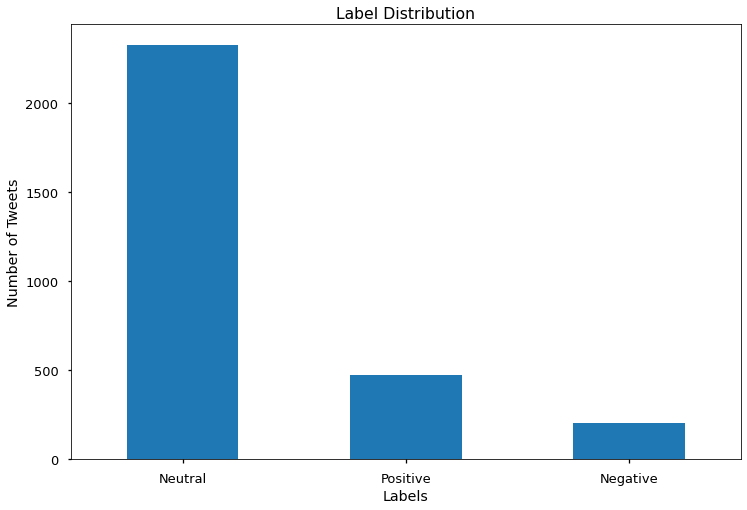

In [5]:
#there are more positive than negative but majority is neutral
plt.style.use('seaborn-talk')
plt.figure() 
fig1 = y.value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Label Distribution')
fig1.set(xticklabels=['Neutral', 'Positive', 'Negative'])
plt.xticks(rotation=0)
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

In [6]:
y.value_counts(normalize=True)

neu    0.775000
pos    0.157667
neg    0.067333
Name: labeled_tweet, dtype: float64

## TF-IDF Vectorizer process for classification

In [7]:
#function to remove punctuation and non-alphabetical characters
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    #text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    #text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return text

#test = clean_text_round1(tweet_df['tweet'][24])
round1 = lambda x: clean_text_round1(x)
X_fake = pd.DataFrame(X.apply(round1))

In [8]:
X = X_fake['tweet']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

tfidf = TfidfVectorizer(stop_words = stopwords_list)
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)
#tfidf_data_train

In [10]:
tfidf_data_train.shape

(2250, 8037)

### Dummy Classifier

In [11]:
from sklearn.dummy import DummyClassifier

In [12]:
dc_classifier = DummyClassifier(strategy='most_frequent')

dc_classifier.fit(tfidf_data_train, y_train)

dc_train_preds = dc_classifier.predict(tfidf_data_train)
dc_test_preds = dc_classifier.predict(tfidf_data_test)

In [13]:
dc_train_score = accuracy_score(y_train, dc_train_preds)
dc_test_score = accuracy_score(y_test, dc_test_preds)

print('Dummy with TF-IDF')
print("Training Accuracy: {:.4}".format(dc_train_score))
print("Testing Accuracy: {:.4}".format(dc_test_score))

Dummy with TF-IDF
Training Accuracy: 0.7742
Testing Accuracy: 0.7773


### Models - NB & RF

In [44]:
#Naiive Bayes Model

nb_classifier = MultinomialNB()

nb_classifier.fit(tfidf_data_train, y_train)

nb_train_preds = nb_classifier.predict(tfidf_data_train)
nb_test_preds = nb_classifier.predict(tfidf_data_test)

In [15]:
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

print('Naiive-Bayes with TF-IDF')
print("Training Accuracy: {:.4}".format(nb_train_score))
print("Testing Accuracy: {:.4}".format(nb_test_score))

Naiive-Bayes with TF-IDF
Training Accuracy: 0.7929
Testing Accuracy: 0.7853


In [16]:
#Random Forest Model

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')

rf_classifier.fit(tfidf_data_train, y_train)

rf_test_preds = rf_classifier.predict(tfidf_data_test)
rf_train_preds = rf_classifier.predict(tfidf_data_train)

In [17]:
rf_acc_score_train = accuracy_score(y_train, rf_train_preds)
rf_acc_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest with TF-IDF')
print("Training Accuracy: {:.4}".format(rf_acc_score_train))
print("Testing Accuracy: {:.4}".format(rf_acc_score))

Random Forest with TF-IDF
Training Accuracy: 0.9991
Testing Accuracy: 0.7813


In [18]:
#feature importance scores
#Decision tree algorithms like classification offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy.
feat_importanceDF_rfc_2 = pd.DataFrame(rf_classifier.feature_importances_, index=tfidf.vocabulary_)
feat_importanceDF_rfc_2.sort_values(by=0,ascending=False).head(20)

,0
years,0.015688
avstå,0.015378
wilmington,0.012091
pictwittercomvkzlcwpgzh,0.011143
angela,0.010870
expanding,0.009672
worrisome,0.008910
laptop,0.008822
imp,0.008809
chronological,0.008619


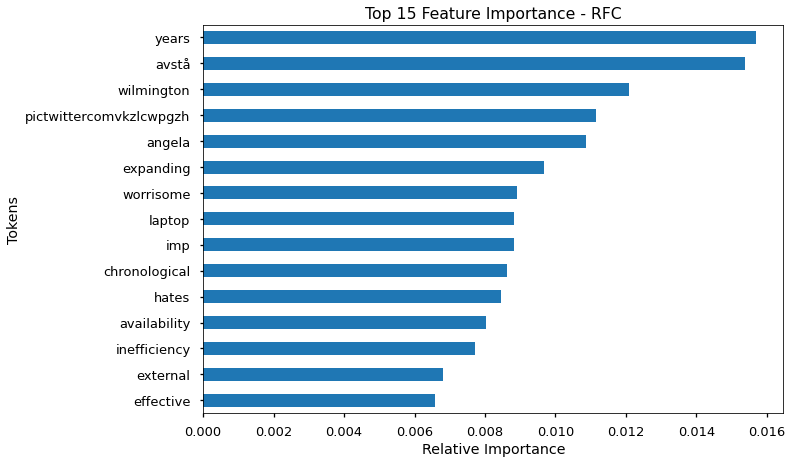

In [19]:
#plot top 5 features for the RFC
feat_importances_2 = pd.Series(rf_classifier.feature_importances_,index=tfidf.vocabulary_)
feat_importances_2.nlargest(15).sort_values().plot(kind='barh')
plt.title("Top 15 Feature Importance - RFC")
plt.xlabel('Relative Importance')
plt.ylabel('Tokens')
plt.show()

In [108]:
#SVM Model
#svm_classifier = svm.SVC(kernel = 'linear', decision_function_shape='ovo')
svm_classifider = LinearSVC()

svm_classifier.fit(tfidf_data_train, y_train)

svm_test_preds = svm_classifier.predict(tfidf_data_test)
svm_train_preds = svm_classifier.predict(tfidf_data_train)

In [109]:
svm_acc_score_train = accuracy_score(y_train, svm_train_preds)
svm_acc_score = accuracy_score(y_test, svm_test_preds)

print('SVM with TF-IDF')
print("Training Accuracy: {:.4}".format(svm_acc_score_train))
print("Testing Accuracy: {:.4}".format(svm_acc_score))

SVM with TF-IDF
Training Accuracy: 0.952
Testing Accuracy: 0.82


In [113]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

In [115]:
plot_coefficients(svm_classifier, tfidf.vocabulary_.keys())

AttributeError: ravel not found

In [114]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [98]:
h = np.array(svm_classifier.coef_).ravel()

In [99]:
h

array([<3x8037 sparse matrix of type '<class 'numpy.float64'>'
	with 13989 stored elements in Compressed Sparse Row format>],
      dtype=object)

In [102]:
f_importances(h, list(tfidf.vocabulary_.keys()))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [105]:
def feature_plot(classifier, feature_names, top_features=4):
     coef = np.array(classifier.coef_).ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     plt.figure(figsize=(18, 7))
     colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
     plt.show()

In [106]:
feature_plot(svm_classifier, tfidf.vocabulary_.keys() )

ValueError: WRITEBACKIFCOPY base is read-only

<Figure size 1296x504 with 0 Axes>

### Confusion Matrix

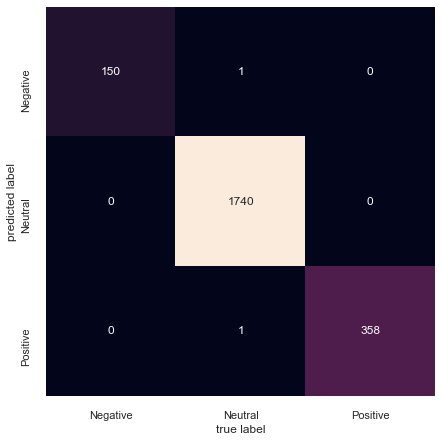

In [20]:
#confusion matrix on train set Random Forest
sns.set()


mat2 = confusion_matrix(y_train, rf_train_preds)
sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

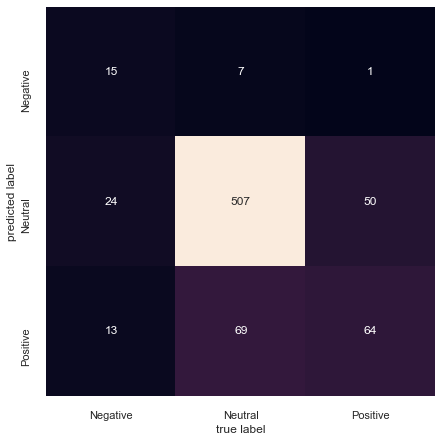

In [21]:
#confusion matrix on test set Random Forest
sns.set()


mat = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [22]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [23]:
print("Precision Score : ",precision_score(y_test, rf_test_preds, 
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, rf_test_preds, 
                                           average='micro'))

Precision Score :  0.7813333333333333
Recall Score :  0.7813333333333333


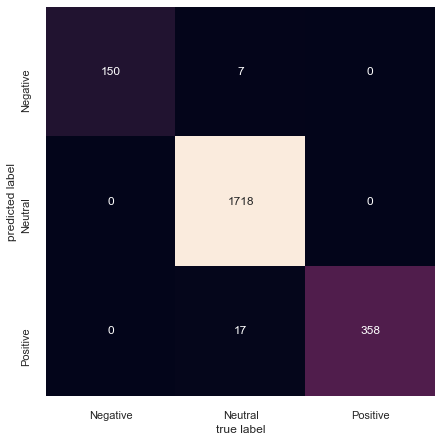

In [51]:
#confusion matrix on train set SVM
sns.set()


mat4 = confusion_matrix(y_train, svm_train_preds)
sns.heatmap(mat4.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

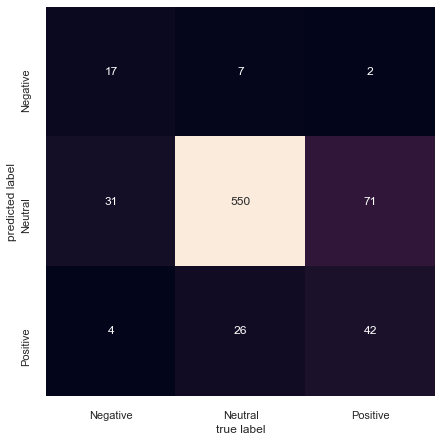

In [52]:
#confusion matrix on test set SVM
sns.set()


mat5 = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(mat5.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [53]:
print("Precision Score : ",precision_score(y_test, svm_test_preds, 
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, svm_test_preds, 
                                           average='micro'))

Precision Score :  0.812
Recall Score :  0.812


### Testing Model with Emotions About Nuclear Energy dataset from CROWDFLOWER

In [24]:
df_crowdflower = pd.read_csv('sentiment_nuclear_power.csv', encoding= 'unicode_escape')

In [25]:
df_crowdflower['sentiment'].replace({'Neutral / author is just sharing information': 'neu', 
                                     'Negative': 'neg', 
                                     'Positive': 'pos',
                                     'Tweet NOT related to nuclear energy': 'neu'}, inplace=True)

In [26]:
X_cf = df_crowdflower['tweet_text']
y_cf = df_crowdflower['sentiment']

In [27]:
y_cf.value_counts(normalize=True)

neu    0.847368
neg    0.100000
pos    0.052632
Name: sentiment, dtype: float64

In [28]:
X_cf_fake = pd.DataFrame(X_cf.apply(round1))
X_cf = X_cf_fake['tweet_text']



tfidf_cf = tfidf.transform(X_cf)

In [29]:
tfidf_cf

<190x8037 sparse matrix of type '<class 'numpy.float64'>'
	with 1545 stored elements in Compressed Sparse Row format>

### Running the Model

In [30]:
rf_cf = rf_classifier.predict(tfidf_cf)

rf_cf_score = accuracy_score(y_cf, rf_cf)
print('Random Forest with TF-IDF using crowdflower data')
print("Accuracy: {:.4}".format(rf_cf_score))

Random Forest with TF-IDF using crowdflower data
Accuracy: 0.6684


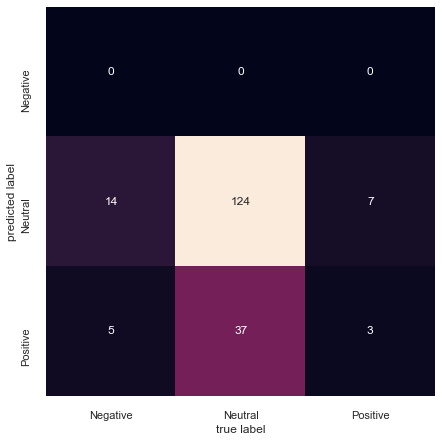

In [31]:
#Confusion Matrix on cf

sns.set()


mat3 = confusion_matrix(y_cf, rf_cf)
sns.heatmap(mat3.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## With Lemmatizer

In [32]:
#reading in 2020 tweets for nuclear energy with labels attached
df_lem = pd.read_csv('tweets_2020_labeled.csv',index_col=0)

In [33]:
#function to remove punctuation and non-alphabetical characters
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    #text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return text

#test = clean_text_round1(tweet_df['tweet'][24])
round1 = lambda x: clean_text_round1(x)
df_lem.tweet = pd.DataFrame(df_lem.tweet.apply(round1))


In [34]:
def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

df_lem.tweet = tokenize(df_lem.tweet)

In [35]:
stopwords_list = stopwords.words('english')
stopwords_list += ['nuclear','energy','…','nuclearenergy','’','核エネルギーの潜在的な危険性は、いくら強調してもし過ぎるということはない。']
df_lem.tweet = df_lem['tweet'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [36]:
p_data =df_lem['tweet']

In [37]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [38]:
# creating a list with all lemmatized outputs
lemmatized_output = []

for listy in p_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [39]:
X_lem = lemmatized_output
# [' '.join(d) for d in processed_data]

y_lem = df_lem['labeled_tweet']
# X[3]

In [40]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer()

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

#tfidf_data_train_lem

In [41]:
#rf

rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0, class_weight = 'balanced')

rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)
rf_train_preds_lem = rf_classifier_lem.predict(tfidf_data_train_lem)

rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_train_score_lem = accuracy_score(y_train_lem, rf_train_preds_lem)
print('Random Forest with Lemmatization Features')
print("Training Accuracy: {:.4}".format(rf_train_score_lem))
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))


Random Forest with Lemmatization Features
Training Accuracy: 0.9975
Testing Accuracy: 0.7733
